# **run load_data.ipynb BEFORE running this!**

In [1]:
import pickle
import os.path
import numpy as np
PATH = 'model_siamese/'
data_file_name = 'data'

with open(data_file_name + '.pickle', 'rb') as handle:
    spectrum, temperature = pickle.load(handle)
    print(f"read data from {data_file_name}.pickle")
print(f"shape of spectrum data: {spectrum.shape}")
print(f"shape of temperature data: {temperature.shape}")
print()
print(f"there are {temperature.shape[0]} spectrums")
print(f"each spectrum is {spectrum.shape[1]} long, which is number of features")

read data from data.pickle
shape of spectrum data: (6000, 10000)
shape of temperature data: (6000, 1)

there are 6000 spectrums
each spectrum is 10000 long, which is number of features


In [2]:
indices_file_name = 'indices'
with open(indices_file_name + '.pickle', 'rb') as handle:
    train_indices, validate_indices, test_indices = pickle.load(handle)
    print(f"got indices from {indices_file_name}.pickle")  
print()
print(f"sets of training indices: {len(train_indices)}")
print(f"number of training indices per set: {len(train_indices[0])}")
print(f"sets of validating indices: {len(validate_indices)}")
print(f"number of validating indices per set: {len(validate_indices[0])}")
print(f"number of testing indices: {len(test_indices)}")
print()
input_dimension = spectrum.shape[1]
print(f"input dimension is:   {input_dimension}")
number_of_samples = spectrum.shape[0]
print(f"number of samples is: {number_of_samples}")
output_dimension = temperature.shape[1]
print(f"output dimension is:  {output_dimension}")

got indices from indices.pickle

sets of training indices: 16
number of training indices per set: 4200
sets of validating indices: 16
number of validating indices per set: 600
number of testing indices: 1200

input dimension is:   10000
number of samples is: 6000
output dimension is:  1


In [ ]:
# reference:
# https://arxiv.org/pdf/1607.02257.pdf Andreas Doumanoglou, 
#   Vassileios Balntas, Rigas Kouskouridas and Tae-Kyun Kim



In [3]:
# how many parameters?
#   "a very simple two-layer ReLU network with p = 2n + d parameters 
#   that can express any labeling of any sample of size n in d dimensions
#   https://arxiv.org/pdf/1611.03530.pdf
#   https://stats.stackexchange.com/questions/320383/relationship-between-
#   model-over-fitting-and-number-of-parameters/320387#320387
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dimension = 100
class SiameseModel(torch.nn.Module):
    def __init__(self, device, input_dim=input_dimension):
        super().__init__()
        self.relu  = nn.ReLU()
        self.hidden_dim = 32
        self.feature_dim = feature_dimension
        self.output_dim = output_dimension
        # siamese part
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(input_dim, self.hidden_dim),
            self.relu,
            # torch.nn.Dropout(0.2),
            torch.nn.Linear(self.hidden_dim, self.hidden_dim),
            self.relu,
            # torch.nn.Dropout(0.2),
            torch.nn.Linear(self.hidden_dim, self.feature_dim)
        )
        self.device = device
        self.to(device)
        self.float()
    def forward(self, input):
        feature = self.sequential(input)
        return feature
class RegressionModel(torch.nn.Module):
    def __init__(self, device, input_dim=feature_dimension):
        super().__init__()
        self.relu  = nn.ReLU()
        self.feature_dim = feature_dimension
        self.output_dim = output_dimension
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(input_dim, self.feature_dim),
            self.relu,
            torch.nn.Linear(self.feature_dim, self.output_dim)
        )
        self.device = device
        self.to(device)
        self.float()
    def forward(self, feature):
        output = self.sequential(feature)
        return output

In [4]:
# add scheduler
# https://arxiv.org/abs/1711.05101
# Adam can substantially benefit from a scheduled learning rate multiplier. 
# The fact that Adam is an adaptive gradient algorithm and as such adapts 
# the learning rate for each parameter does not rule out the possibility to 
# substantially improve its performance by using a global learning rate 
# multiplier, scheduled, e.g., by cosine annealing.
class Scheduler():
    def __init__(self, optimizer, patience, minimum_learning_rate, factor):
        # wait 'patience' number of epochs to change learning rate
        # learning rates' lower bound: 'minimum_learning_rate'
        # update learning rate by 'factor'ArithmeticError
        self.optimizer = optimizer
        self.patience = patience
        self.minimum_learning_rate = minimum_learning_rate
        self.factor = factor
        # use 'min' mode because:
        # we are monitoring loss
        # we do stuff when loss stops DEcreasing
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', patience=self.patience,
            factor=self.factor, min_lr=self.minimum_learning_rate,
        )
        # print(f"SCHEDULER: {self.scheduler}:")
        # print(f"\tpatience = {self.patience}, factor = {self.factor}" + 
        #       f"minimum_learning_rate = {minimum_learning_rate}")
    def __call__(self, validation_loss):
        self.scheduler.step(validation_loss)

In [5]:
# early stopping
# https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping
# -with-pytorch/
class EarlyStopping():
    def __init__(self, patience, min_delta):
        # if no improvement after 'patience' epochs, stop training
        # to count as improvement, need to change by 'min_delta' amount
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, loss):
        if self.best_loss == None:
            self.best_loss = loss
        elif self.best_loss - loss >= self.min_delta:
            # improved enough
            self.best_loss = loss
            self.counter = 0
        elif self.best_loss - loss < self.min_delta:
            # did NOT improve enough :C
            self.counter += 1
            if self.counter >= self.patience:
                # it's stopping time! :C
                # no need reset early_stop, because we only use it once
                self.early_stop = True 

In [6]:
class SaveBestModel():
    def __init__(self, current_best_loss = float('inf')):
        self.current_best_loss = current_best_loss
        self.itsSavingTime = False
    def __call__(self, current_loss, model_1, model_2, round):
        # no save optimizer, since we are using model for inference
        if current_loss < self.current_best_loss:
            self.current_best_loss = current_loss
            self.itsSavingTime = True
        if self.itsSavingTime == True:
            torch.save(model_1.state_dict(), PATH + f'fea_round={round}' + '.pth')
            torch.save(model_2.state_dict(), PATH + f'reg_round={round}' + '.pth')
# inherits from SaveBestModel
class SaveBestModel_filename(SaveBestModel):
    def __init__(self, current_best_loss = float('inf')):
        SaveBestModel.__init__(self, current_best_loss = float('inf'))
    def __call__(self, current_loss, round):
        # no save optimizer, since we are using model for inference
        if current_loss < self.current_best_loss:
            self.current_best_loss = current_loss
            self.current_best_model_1_filename = PATH + f'fea_round={round}' + '.pth'
            self.current_best_model_2_filename = PATH + f'reg_round={round}' + '.pth'

In [14]:
# StandardScaler example
from sklearn.preprocessing import StandardScaler
arr = np.asarray([1, 2, 3]).reshape(-1, 1)
sc = StandardScaler()
arr = sc.fit_transform(arr)
arr

array([[-1.22474487],
       [ 0.        ],
       [ 1.22474487]])

In [7]:
import random
import copy
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
# reference:
# https://colab.research.google.com/github/maticvl/dataHacker/
# blob/master/pyTorch/014_siameseNetwork.ipynb#scrollTo=gD1BFFm_z7aj
class SiameseDataset(torch.utils.data.TensorDataset):
    def __init__(self, X, y):
        # X is already normalized
        self.y = y
        self.y_normalize = torch.Tensor(
            preprocessing.normalize(np.copy(y), axis=0)).to(device)
        self.X = torch.Tensor(
            preprocessing.normalize(np.copy(X), axis=0)).to(device)
        self.indices = range(len(y))
    # length: number of elements in subset of X_IDs
    def __len__(self):
        return len(self.y)
    # get item by index in [m, n]
    def __getitem__(self, index): # assume index lies within subset_X_IDs
        # property: randomly sample two inputs,
        # return: the two inputs, 
        #   and binary label for whethery they have same class
        input_1_id = index
        input_1 = self.X[input_1_id]
        label_1 = self.y[input_1_id]
        label_1_normalize = self.y_normalize[input_1_id]
        input_2_id = random.choice(self.indices)
        input_2 = self.X[input_2_id]
        label_2 = self.y[input_2_id]
        label_2_normalize = self.y_normalize[input_2_id]
        return input_1, input_2, label_1, label_2, label_1_normalize, label_2_normalize

In [8]:
# normalize example
from sklearn import preprocessing
t = np.asarray([
    [0, 0, 0],
    [1, 2, 3],
    [4, 5, 6]
])
preprocessing.normalize(t, axis=0)

array([[0.        , 0.        , 0.        ],
       [0.24253563, 0.37139068, 0.4472136 ],
       [0.9701425 , 0.92847669, 0.89442719]])

In [9]:
import torch.nn.functional as F
class FeatureLoss(torch.nn.Module):
    def __init__(self):
        super(FeatureLoss, self).__init__()

    def forward(self, feature_1, feature_2, label_1, label_2):
        mse = nn.MSELoss()
        feature_distance = mse(feature_1, feature_2)
        # print(feature_distance)
        label_distance = mse(label_1, label_2)
        # print(label_distance)
        return abs(feature_distance - label_distance)
    
# t_ = FeatureLoss()
# l = t_(a, b, torch.Tensor([[0, 0], [1, 1]]), torch.Tensor([[0, 0], [1, 1]]))
# l.item()

In [10]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import optim
import numpy as np

# return: train_loss, validation_loss, current model
class trainer():
    def __init__(self, feature_model, regress_model, n_epochs, 
                 batch_size, 
                 feature_learning_rate,
                 regress_learning_rate,
                 cross_validation_round):
        super().__init__()
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.cross_validation_round = cross_validation_round
        self.device = device

        self.feature_learning_rate = feature_learning_rate
        self.feature_model = feature_model
        self.feature_model.apply(self.initializer)
        self.feature_optimizer = optim.AdamW(self.feature_model.parameters(), 
                        lr=feature_learning_rate, weight_decay=3e-3) 
        self.feature_scheduler = Scheduler(optimizer=self.feature_optimizer, 
                        minimum_learning_rate=1e-6,
                        patience=5,
                        factor=0.5)
        self.feature_criterion = FeatureLoss()
        
        self.regress_learning_rate = regress_learning_rate
        self.regress_model = regress_model
        self.regress_model.apply(self.initializer)
        self.regress_optimizer = optim.AdamW(self.regress_model.parameters(), 
                        lr=regress_learning_rate, weight_decay=3e-3) 
        self.regress_scheduler = Scheduler(optimizer=self.regress_optimizer, 
                        minimum_learning_rate=1e-6,
                        patience=5,
                        factor=0.5)
        self.regress_criterion = nn.MSELoss()
        
        self.stopper = EarlyStopping(patience=5, min_delta=1e-6)
    # use He initialization (because of RELU units in model definition)  
    def initializer(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_normal_(layer.weight) # normal version
    def get_loss(self, train_data, train_label, test_data, test_label):
        # datasets
        train_set = SiameseDataset(train_data, train_label)
        val_set = SiameseDataset(train_data, test_label)
        # dataloaders
        loader_args = dict(batch_size=self.batch_size)
        train_loader = DataLoader(train_set, shuffle=True, drop_last=True, 
                                  **loader_args)
        val_loader = DataLoader(val_set, shuffle=True, drop_last=True, 
                                **loader_args)
        """SETUP"""
        feature_train_loss = []
        feature_valid_loss = []
        regress_train_loss = []
        regress_valid_loss = []

        # scheduler action affects the optimizer!
        saver = SaveBestModel()

        for epoch in range(0, self.n_epochs):
            # training
            feature_train_loss_thisepoch = []
            regress_train_loss_thisepoch = []
            
            for i, data in enumerate(train_loader, 0):
                x1, x2, y1, y2, y1_normal, y2_normal = data
                # print(f"train: shape of x1: {x1.shape}")
                # get features
                f1_pred = self.feature_model(x1.to(self.device))
                f2_pred = self.feature_model(x2.to(self.device))
                # get regressions
                y1_pred = self.regress_model(f1_pred.to(self.device))
                regress_loss_1 = self.regress_criterion(
                    y1_pred.to(self.device).float(), y1.to(self.device).float())
                self.regress_optimizer.zero_grad()
                # print(f"regress_loss_1's datatype: {regress_loss_1.dtype}")
                regress_loss_1.backward(retain_graph=True)
                self.regress_optimizer.step()
                regress_train_loss_thisepoch.append(regress_loss_1.item())

                y2_pred = self.regress_model(f2_pred.to(self.device))
                regress_loss_2 = self.regress_criterion(
                    y2_pred.to(self.device).float(), y2.to(self.device).float())
                self.regress_optimizer.zero_grad()
                regress_loss_2.backward(retain_graph=True)
                self.regress_optimizer.step()
                regress_train_loss_thisepoch.append(regress_loss_2.item())

                feature_loss = self.feature_criterion(
                    f1_pred.to(self.device).float(), f2_pred.to(self.device).float(), 
                    y1_normal.to(self.device).float(), y2_normal.to(self.device).float())
                self.feature_optimizer.zero_grad()
                feature_loss.backward()
                self.feature_optimizer.step()
                feature_train_loss_thisepoch.append(feature_loss.item())
            feature_train_loss.append(np.mean(feature_train_loss_thisepoch))
            regress_train_loss.append(np.mean(regress_train_loss_thisepoch))

            # validation
            feature_valid_loss_thisepoch = []
            regress_valid_loss_thisepoch = []
            for i, data in enumerate(val_loader, 0):
                with torch.no_grad():
                    x1, x2, y1, y2, y1_normal, y2_normal = data
                    # print(f"validate: shape of x1: {x1.shape}")
                    f1_pred = self.feature_model(x1.to(self.device))
                    f2_pred = self.feature_model(x2.to(self.device))

                    y1_pred = self.regress_model(f1_pred.to(self.device))
                    regress_loss_1 = self.regress_criterion(
                        y1_pred.to(self.device), y1.to(self.device))
                    regress_valid_loss_thisepoch.append(regress_loss_1.item())

                    y2_pred = self.regress_model(f2_pred.to(self.device))
                    regress_loss_2 = self.regress_criterion(
                        y2_pred.to(self.device), y2.to(self.device))
                    regress_valid_loss_thisepoch.append(regress_loss_2.item())

                    feature_loss = self.feature_criterion(
                        f1_pred.to(self.device), f2_pred.to(self.device), 
                        y1_normal.to(self.device), y2_normal.to(self.device))
                    feature_valid_loss_thisepoch.append(feature_loss.item())
            feature_valid_loss.append(np.mean(feature_valid_loss_thisepoch))
            regress_valid_loss.append(np.mean(regress_valid_loss_thisepoch))
            # save best model
            saver(current_loss=np.mean(feature_valid_loss_thisepoch), 
                  model_1=self.feature_model, 
                  model_2=self.regress_model,
                  round=self.cross_validation_round
                  )
            # scheduler & early stopping
            self.feature_scheduler(np.mean(feature_valid_loss_thisepoch))
            self.regress_scheduler(np.mean(regress_valid_loss_thisepoch))

            self.stopper(np.mean(regress_valid_loss_thisepoch))
            if self.stopper.early_stop == True:
                print(f"\tEARLY STOPPING @ epoch {epoch}")
                break
        # plot result w.r.t epoch
        #plot feature
        plt.subplot(1, 2, 1)
        plt.plot(feature_train_loss)
        plt.plot(feature_valid_loss)
        plt.title("FEATURE")
        #plot regression
        plt.subplot(1, 2, 2)
        plt.plot(regress_train_loss)
        plt.plot(regress_valid_loss)
        plt.title("REGRESS")
        plt.show()
        min_feature_valid_loss = np.min(feature_valid_loss)
        min_feature_train_loss = np.min(feature_train_loss)
        min_regress_valid_loss = np.min(regress_valid_loss)
        min_regress_train_loss = np.min(regress_train_loss)
        return min_feature_valid_loss, min_feature_train_loss, self.feature_model, min_regress_valid_loss, min_regress_train_loss, self.regress_model

it's training time
necessary params count: 22000
actual params count: 321418
	total trainable parameters: 321418
number of epochs: 2000, batch size: 64, device: cuda, learning rates 5e-05,5e-05
NOTE: training loss is blue, validation loss is orange

training starts:
cross-validation round no.0
	EARLY STOPPING @ epoch 218


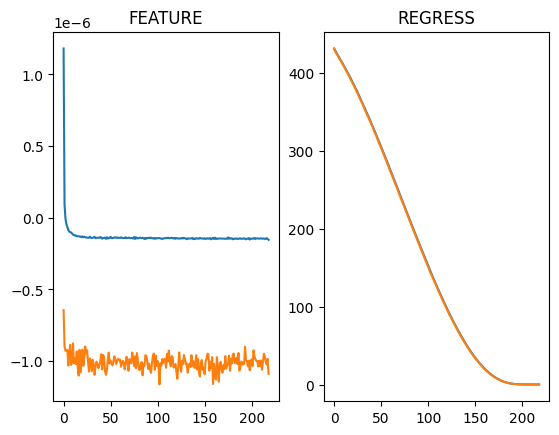

	minimum feature train loss:      -1.5453888157533304e-07
	minimum feature valid loss:      -1.1634897671481465e-06
	minimum regress train loss:      0.15089018195867537
	minimum regress valid loss:      0.1344355000733761
	time: 2023-06-04 09:59:22

training and validation loss, across cross-validation rounds


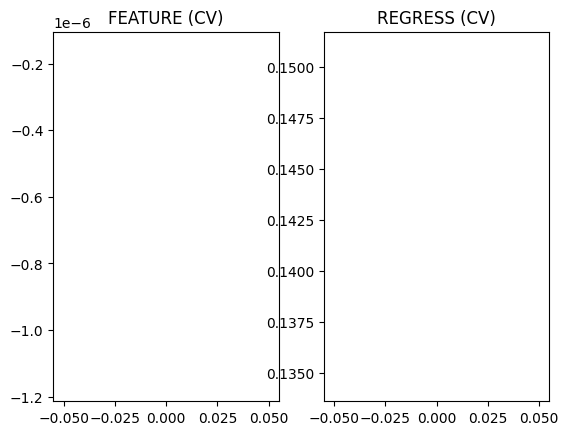

the best feature model is:    model_siamese/fea_round=0.pth
the best regression model is: model_siamese/reg_round=0.pth


In [12]:
# Theory suggests that when multiplying the batch size by k, 
# one should multiply the learning rate by sqrt(k) to keep the variance 
# in the gradient expectation constant. See page 5 at A. Krizhevsky. 
# One weird trick for parallelizing convolutional neural networks: 
# https://arxiv.org/abs/1404.5997
# 
# However, recent experiments with large mini-batches suggest for a simpler 
# linear scaling rule, i.e multiply your learning rate by k when using 
# mini-batch size of kN. See P.Goyal et al.: Accurate, Large Minibatch SGD: 
# Training ImageNet in 1 Hour 
# https://arxiv.org/abs/1706.02677
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import copy
print("it's training time")

n_epochs = 2000
batch_size = 64
feature_learning_rate = 5e-5
regress_learning_rate = 5e-5

"""model setup"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_mdl = SiameseModel(device=device, input_dim=input_dimension)
regress_mdl = RegressionModel(device=device, input_dim=feature_dimension)

print(f"necessary params count: {2 * number_of_samples + input_dimension}")
total_params = sum(p.numel() for p in feature_mdl.parameters())
print(f"actual params count: {total_params}")
total_params_trainable = sum(p.numel() for p in feature_mdl.parameters() 
                             if p.requires_grad)
print(f"\ttotal trainable parameters: {total_params_trainable}")

feature_train_losses = []
feature_valid_losses = []
regress_train_losses = []
regress_valid_losses = []
print(f"number of epochs: {n_epochs}, batch size: {batch_size}, " + 
      f"device: {feature_mdl.device}, learning rates {feature_learning_rate}," +
      f"{regress_learning_rate}")
print("NOTE: training loss is blue, validation loss is orange")
print()
print("training starts:")

Path(PATH).mkdir(parents=True, exist_ok=True)
saver = SaveBestModel_filename()
for cross_validation_round, (train, validate) in enumerate(zip(train_indices, validate_indices)):
    print(f"cross-validation round no.{cross_validation_round}")
    # use indices to extract training & testing set for current 
    # cross-validation round
    train_data, train_label = spectrum[train], temperature[train]
    validate_data, validate_label = spectrum[validate], temperature[validate]
    trainer_object = trainer(feature_model=feature_mdl,
                             regress_model=regress_mdl,
                             n_epochs=n_epochs,
                             batch_size=batch_size,
                             feature_learning_rate=feature_learning_rate,
                             regress_learning_rate=regress_learning_rate,
                             cross_validation_round=cross_validation_round)
    feature_valid_loss, feature_train_loss, feature_model, regress_valid_loss, regress_train_loss, regress_model = trainer_object.get_loss(
                                        train_data, 
                                        train_label, 
                                        validate_data, 
                                        validate_label)
    feature_train_losses.append(feature_train_loss)
    feature_valid_losses.append(feature_valid_loss)
    regress_train_losses.append(regress_train_loss)
    regress_valid_losses.append(regress_valid_loss)

    saver(current_loss=feature_valid_loss + regress_valid_loss, round=cross_validation_round)
    print(f"\tminimum feature train loss:      {feature_train_loss}")
    print(f"\tminimum feature valid loss:      {feature_valid_loss}")
    print(f"\tminimum regress train loss:      {regress_train_loss}")
    print(f"\tminimum regress valid loss:      {regress_valid_loss}")
    print("\ttime: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

    break
print()
print("training and validation loss, across cross-validation rounds")
plt.subplot(1, 2, 1)
plt.plot(feature_train_losses)
plt.plot(feature_valid_losses)
plt.title("FEATURE (CV)")
plt.subplot(1, 2, 2)
plt.plot(regress_train_losses)
plt.plot(regress_valid_losses)
plt.title("REGRESS (CV)")
plt.show()

best_feature_model_filename = saver.current_best_model_1_filename
best_regress_model_filename = saver.current_best_model_2_filename
print(f"the best feature model is:    {best_feature_model_filename}")
print(f"the best regression model is: {best_regress_model_filename}")

In [17]:
print(f"feature min validation losses: {np.min(feature_valid_losses)}") 
print(f"\tstd: {np.std(feature_valid_losses)}")
print(f"regress min validation losses: {np.min(regress_valid_losses)}") 
print(f"\tstd: {np.std(regress_valid_losses)}")
print()

print("loading best model")
best_feature_model = SiameseModel(device=device, input_dim=input_dimension)
print(best_feature_model.load_state_dict(torch.load(best_feature_model_filename)))
best_regress_model = RegressionModel(device=device, input_dim=feature_dimension)
print(best_regress_model.load_state_dict(torch.load(best_regress_model_filename)))
print()

print("it's inference time!")
test = test_indices
test_data, test_label = spectrum[test], temperature[test]
test_set = SiameseDataset(
            test_data, 
            test_label)
loader_args = dict(batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True, drop_last=True, 
                            **loader_args)
feature_test_losses = []
regress_test_losses = []
feature_test_criterion = FeatureLoss()
regress_test_criterion = nn.MSELoss()
for i, data in enumerate(test_loader, 0):
    with torch.no_grad():
        x1, x2, y1, y2, y1_normal, y2_normal = data
        # print(f"validate: shape of x1: {x1.shape}")
        f1_pred = best_feature_model(x1.to(device))
        f2_pred = best_feature_model(x2.to(device))

        y1_pred = best_regress_model(f1_pred.to(device))
        regress_loss_1 = regress_test_criterion(
            y1_pred.to(device), y1.to(device))
        regress_test_losses.append(regress_loss_1.item())

        y2_pred = best_regress_model(f2_pred.to(device))
        regress_loss_2 = regress_test_criterion(
            y2_pred.to(device), y2.to(device))
        regress_valid_losses.append(regress_loss_2.item())

        feature_loss = feature_test_criterion(
            f1_pred.to(device), f2_pred.to(device), 
            y1_normal.to(device), y2_normal.to(device))
        feature_test_losses.append(feature_loss.item())
print(f"feature mean test loss: {np.mean(feature_test_losses)}")
print(f"regress mean test loss: {np.mean(regress_test_losses)}") 

feature min validation losses: -1.1634897671481465e-06
	std: 1.656300540248002e-07
regress min validation losses: 0.12783715521997024
	std: 0.016129173341523938

loading best model
<All keys matched successfully>
<All keys matched successfully>

it's inference time!
feature mean test loss: -4.72458973869531e-07
regress mean test loss: 0.15599221872051275


In [21]:
number_figures = 10
import matplotlib.pyplot as plt

spec_normalize = preprocessing.normalize(np.copy(spectrum), axis=0)

indices = torch.randint(0, len(spectrum),(number_figures,)).unique()
for i in indices:
    print(f"we use {i}th example")
    # change: cast i to int, since pandas not work with torch.int64
    # changed: removed figure, since the output is just one number
    spec = np.asarray(spec_normalize[int(i)]).flatten()
    temp = np.asarray(temperature[int(i)]).flatten()
    
    # print(np.asarray(spectrum[int(i)]).flatten())
    # print(spec)
    feature = best_feature_model(torch.Tensor(spec).to(device))
    prediction = best_regress_model(feature).detach().cpu().flatten()
    
    prediction = prediction.item()
    ground_truth = temp.item()
    # recover data from normalization
    print(f"-----------------------------------------------------")
    print(f"\tthe prediction is: {prediction}")
    print(f"\tthe ground truth is: {ground_truth}")
    print(f"\tthe difference is: {prediction - ground_truth}")


we use 40th example
-----------------------------------------------------
	the prediction is: 21.32419204711914
	the ground truth is: 21.5
	the difference is: -0.17580795288085938
we use 1548th example
-----------------------------------------------------
	the prediction is: 21.322723388671875
	the ground truth is: 21.5
	the difference is: -0.177276611328125
we use 1668th example
-----------------------------------------------------
	the prediction is: 21.321609497070312
	the ground truth is: 21.7
	the difference is: -0.3783905029296868
we use 3298th example
-----------------------------------------------------
	the prediction is: 21.319686889648438
	the ground truth is: 21.7
	the difference is: -0.3803131103515618
we use 3492th example
-----------------------------------------------------
	the prediction is: 21.325956344604492
	the ground truth is: 21.8
	the difference is: -0.4740436553955085
we use 4832th example
-----------------------------------------------------
	the prediction i

# **skip cell 14 for now (it's in template file!)**